In [1]:
import pandas as pd
import numpy as np
import math
from scipy.stats import pearsonr
from scipy.stats import mode
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
datos = pd.read_csv('datos.csv', sep=',')
print(datos.shape)
datos.head()

(61399, 41)


/var/folders/ty/0bh0gn7d63593pvgpfv35k0m0000gn/T/ipykernel_63636/4193976938.py:1: DtypeWarning: Columns (32,33,34) have mixed types. Specify dtype option on import or set low_memory=False.
  datos = pd.read_csv('datos.csv', sep=',')


,FECHA_INSCRITO,INR_NACI_FECHA,INR_GRADO,GRD_NOMBRE,GRD_NIVEL_ESCOLAR,D_SEXO,INR_RES_CIUDAD,CIU_NOMBRE,INR_RES_LOCALIDAD,LOC_NOMBRE,...,AULAS Preescolar,AULAS 1-11,ÁREAS - PREESCOLAR,ÁREAS 1-11,CUPOS 2024,EDAD_INR,Decil ICFES,Ranking ICFES,DEMANDA VS CAPACIDAD %,DEMANDA VS OFERTA %
0,2023-09-01,2018-12-17,0,TRANSICIÓN (GRADO 0),PREESCOLAR,M,11001,BOGOTÁ D.C.,5,USME,...,1,13,30.91,482.54,120.0,4.0,4th Decile,558.0,36.038961,25.833333
1,2023-09-01,2017-07-11,1,PRIMERO,BASICA PRIMARIA,M,11001,BOGOTÁ D.C.,8,KENNEDY,...,NaN,19,0,1218.8899999999999,140.0,6.0,2nd Decile,613.0,17.726658,25.714286
2,2023-09-01,2015-06-01,1,PRIMERO,BASICA PRIMARIA,F,11001,BOGOTÁ D.C.,7,BOSA,...,NaN,34,0,2121,248.0,8.0,3rd Decile,583.0,39.191291,28.225806
3,2023-09-01,2020-01-23,-1,JARDIN,PREESCOLAR,M,11001,BOGOTÁ D.C.,7,BOSA,...,12,33,621.5,2462,120.0,3.0,1st Decile,656.0,6.932890,102.500000
4,2023-09-01,2019-02-19,0,TRANSICIÓN (GRADO 0),PREESCOLAR,F,11001,BOGOTÁ D.C.,19,CIUDAD BOLIVAR,...,1,8,29.09,331.23,320.0,4.0,9th Decile,135.0,8.992806,28.750000


In [3]:
embeddings = pd.read_csv('embedding_df.csv', sep=',')

In [4]:
embeddings = embeddings.drop('texto', axis=1)
print(embeddings.shape)
embeddings.head()

(61399, 768)


,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,0.026229,0.009000,0.027059,-0.056850,-0.022927,-0.005288,0.039937,0.010887,-0.025599,-0.006642,...,0.000033,0.005945,0.041146,-0.051710,-0.006032,0.000908,-0.006962,0.036058,-0.007850,0.002692
1,-0.028091,-0.020587,0.045902,-0.012714,-0.010489,0.010037,0.030937,-0.001339,-0.029377,0.008227,...,0.029167,0.036651,0.015262,-0.020024,0.010967,0.017517,-0.029042,-0.009266,0.004278,0.005128
2,-0.008352,0.004420,0.049039,-0.059168,-0.001420,0.016631,-0.006374,0.009776,-0.045339,-0.008731,...,0.019960,0.030664,0.026876,-0.022234,0.016187,0.031417,-0.027426,0.024747,0.010794,0.052607
3,0.019214,-0.022669,0.035043,-0.057416,-0.011307,-0.013409,0.005252,-0.020668,-0.010588,0.026330,...,0.022925,-0.017690,0.011537,-0.000696,0.012235,-0.008382,-0.019532,0.010103,-0.009285,0.020471
4,0.024607,0.026025,0.021370,-0.078242,-0.015760,-0.006322,0.018827,0.015122,-0.034345,-0.007886,...,-0.011344,0.005055,0.051883,-0.031466,0.014314,0.027445,-0.009717,0.045723,-0.002767,0.027288


In [30]:
X = embeddings

# Aplicar PCA para reducir la dimensionalidad y retener el 95% de la varianza
pca = PCA(n_components=0.80, random_state=123)
X_pca = pca.fit_transform(X)

In [31]:
n_components = pca.n_components_
print(f"Numero de componentes retenidos: {n_components}")

Numero de componentes retenidos: 9


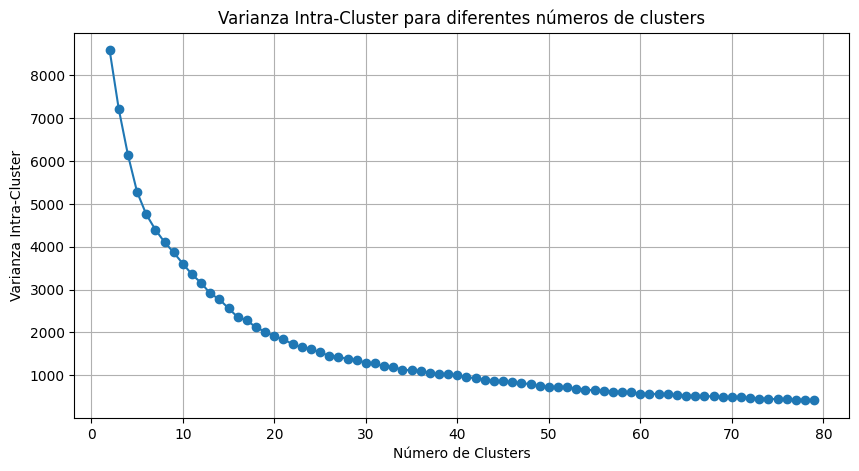

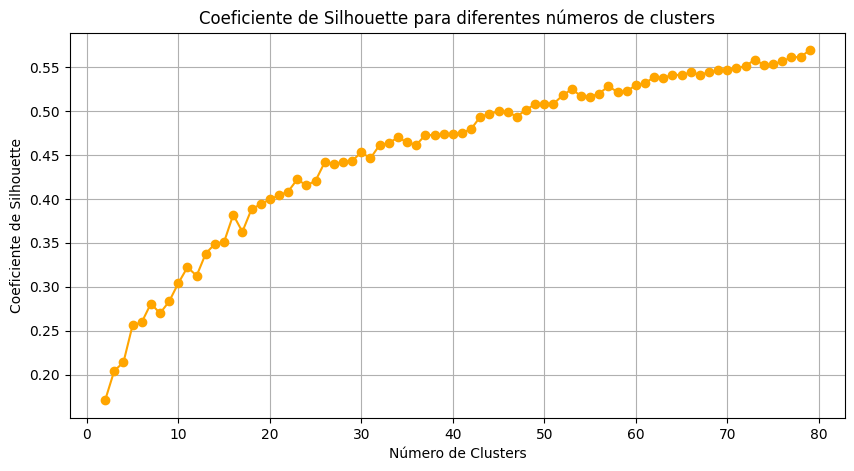

El número óptimo de clusters según el coeficiente de Silhouette es: 79


In [32]:
varianza_intra_cluster = []
silhouettes = []
Y = {}
range_clusters = range(2, 80)  

for k in range_clusters:
    kmeans = KMeans(n_clusters=k, random_state=123, n_init=10)
    kmeans.fit(X_pca)
    
    # Varianza intra-cluster (inercia)
    varianza_intra_cluster.append(kmeans.inertia_)
    
    # Coeficiente de Silhouette
    try:
        silhouette = silhouette_score(X, kmeans.labels_)
    except ValueError:
        silhouette = 0  # El índice de Silhouette sólo se puede calcular cuando se tiene K > 1
    
    silhouettes.append(silhouette)
    
    # Almacenar las etiquetas predichas
    Y[k] = kmeans.labels_

# Graficar la Varianza Intra-Cluster
plt.figure(figsize=(10, 5))
plt.plot(range_clusters, varianza_intra_cluster, marker='o', label='Varianza Intra-Cluster')
plt.title('Varianza Intra-Cluster para diferentes números de clusters')
plt.xlabel('Número de Clusters')
plt.ylabel('Varianza Intra-Cluster')
plt.grid(True)
plt.show()

# Graficar el Coeficiente de Silhouette
plt.figure(figsize=(10, 5))
plt.plot(range_clusters, silhouettes, marker='o', label='Coeficiente de Silhouette', color='orange')
plt.title('Coeficiente de Silhouette para diferentes números de clusters')
plt.xlabel('Número de Clusters')
plt.ylabel('Coeficiente de Silhouette')
plt.grid(True)
plt.show()

# Determinar el número óptimo de clusters según el coeficiente de Silhouette
optimal_clusters_silhouette = range_clusters[silhouettes.index(max(silhouettes))]
print(f"El número óptimo de clusters según el coeficiente de Silhouette es: {optimal_clusters_silhouette}")

In [34]:
kmeans = KMeans(n_clusters=optimal_clusters_silhouette, random_state=123, n_init=10)
kmeans.fit(X_pca)

KMeans(n_clusters=79, n_init=10, random_state=123)

In [35]:
# Obtener las etiquetas de cada punto (a qué clúster pertenece)
etiquetas = kmeans.labels_

# Agregar las etiquetas al DataFrame original para ver a qué clúster pertenece cada observación
datos_con_clust = datos.copy()
datos_con_clust['cluster'] = etiquetas

# Contar cuántos puntos hay en cada clúster
conteo_por_clúster = datos_con_clust['cluster'].value_counts()
print("Número de puntos en cada clúster:")
print(conteo_por_clúster)

Número de puntos en cada clúster:
cluster
2     3760
7     3660
12    2302
4     2226
9     2116
      ... 
64     173
69     135
78     129
68     120
15      89
Name: count, Length: 79, dtype: int64


In [36]:
# Mostrar las primeras filas del DataFrame para verificar que las etiquetas se han agregado
datos_con_clust.head()

,FECHA_INSCRITO,INR_NACI_FECHA,INR_GRADO,GRD_NOMBRE,GRD_NIVEL_ESCOLAR,D_SEXO,INR_RES_CIUDAD,CIU_NOMBRE,INR_RES_LOCALIDAD,LOC_NOMBRE,ZON_NOMBRE,BAR_NOMBRE,UPZ_NOMBRE,INR_DISCAPACIDAD,DIT_NOMBRE,TAE_NOMBRE,ETN_NOMBRE,INR_ES_VICTIMA,PAI_NOMBRE,INE_NOMBRE_INTERNO,ASIGNADO_GRADO,ASIGNADO_OPCION,ASIGNADO_DANE_SEDE,ASIGNADO_DANE_IED,ASIGNADO_LOCALIDAD,ASIGNADO_FECHA,Puntaje ICFES 11,Evaluados ICFES 11,CAPACIDAD INSTALADA - PREESCOLAR,CAPACIDAD INSTALADA - 1-11,CAPACIDAD INSTALADA - Total,AULAS Preescolar,AULAS 1-11,ÁREAS - PREESCOLAR,ÁREAS 1-11,CUPOS 2024,EDAD_INR,Decil ICFES,Ranking ICFES,DEMANDA VS CAPACIDAD %,DEMANDA VS OFERTA %,cluster
0,2023-09-01,2018-12-17,0,TRANSICIÓN (GRADO 0),PREESCOLAR,M,11001,BOGOTÁ D.C.,5,USME,URBANA,BARRANQUILLITA,GRAN YOMASA,99,NO APLICA,NO APLICA,NO APLICA,0,COLOMBIA,LIBERADO NO ACEPTA ASIGNACION,0.0,2.0,111001045705,111001045705,USME,2023-10-29,51.382688,99.200000,15.455000,292.448485,307.903485,1,13,30.91,482.54,120.0,4.0,4th Decile,558.0,36.038961,25.833333,2
1,2023-09-01,2017-07-11,1,PRIMERO,BASICA PRIMARIA,M,11001,BOGOTÁ D.C.,8,KENNEDY,URBANA,DINTALITO,PATIO BONITO,99,NO APLICA,NO APLICA,NO APLICA,0,COLOMBIA,ASIGNADO ACEPTADO,1.0,2.0,111001098906,111001098906,KENNEDY,2023-12-20,50.409017,121.900000,0.000000,738.721212,738.721212,NaN,19,0,1218.8899999999999,140.0,6.0,2nd Decile,613.0,17.726658,25.714286,14
2,2023-09-01,2015-06-01,1,PRIMERO,BASICA PRIMARIA,F,11001,BOGOTÁ D.C.,7,BOSA,URBANA,SAN BERNARDINO XXV,TINTAL SUR,99,NO APLICA,NO APLICA,NO APLICA,0,COLOMBIA,ASIGNADO ACEPTADO,1.0,1.0,111001106950,111001106950,BOSA,2023-12-20,50.909332,292.100000,0.000000,1285.454545,1285.454545,NaN,34,0,2121,248.0,8.0,3rd Decile,583.0,39.191291,28.225806,1
3,2023-09-01,2020-01-23,-1,JARDIN,PREESCOLAR,M,11001,BOGOTÁ D.C.,7,BOSA,URBANA,BOSA,BOSA CENTRAL,99,NO APLICA,NO APLICA,NO APLICA,0,COLOMBIA,FORMALIZADO,-1.0,1.0,111001800457,111001800457,BOSA,2023-10-29,49.384615,102.333333,310.750000,1492.121212,1802.871212,12,33,621.5,2462,120.0,3.0,1st Decile,656.0,6.932890,102.500000,6
4,2023-09-01,2019-02-19,0,TRANSICIÓN (GRADO 0),PREESCOLAR,F,11001,BOGOTÁ D.C.,19,CIUDAD BOLIVAR,URBANA,ESPINO,ISMAEL PERDOMO,99,NO APLICA,NO APLICA,NO APLICA,0,COLOMBIA,ASIGNADO ACEPTADO,0.0,71.0,111001045004,111001086801,CIUDAD BOLIVAR,2023-11-28,56.960000,NaN,22.376923,254.792308,277.169231,1,8,29.09,331.23,320.0,4.0,9th Decile,135.0,8.992806,28.750000,7


In [15]:
datos_con_clust.columns

Index(['FECHA_INSCRITO', 'INR_NACI_FECHA', 'INR_GRADO', 'GRD_NOMBRE',
       'GRD_NIVEL_ESCOLAR', 'D_SEXO', 'INR_RES_CIUDAD', 'CIU_NOMBRE',
       'INR_RES_LOCALIDAD', 'LOC_NOMBRE', 'ZON_NOMBRE', 'BAR_NOMBRE',
       'UPZ_NOMBRE', 'INR_DISCAPACIDAD', 'DIT_NOMBRE', 'TAE_NOMBRE',
       'ETN_NOMBRE', 'INR_ES_VICTIMA', 'PAI_NOMBRE', 'INE_NOMBRE_INTERNO',
       'ASIGNADO_GRADO', 'ASIGNADO_OPCION', 'ASIGNADO_DANE_SEDE',
       'ASIGNADO_DANE_IED', 'ASIGNADO_LOCALIDAD', 'ASIGNADO_FECHA',
       'Puntaje ICFES 11', 'Evaluados ICFES 11',
       'CAPACIDAD INSTALADA - PREESCOLAR', 'CAPACIDAD INSTALADA - 1-11',
       'CAPACIDAD INSTALADA - Total', 'AULAS  Preescolar', 'AULAS  1-11',
       'ÁREAS - PREESCOLAR', 'ÁREAS   1-11', 'CUPOS 2024', 'EDAD_INR',
       'Decil ICFES', 'Ranking ICFES', 'DEMANDA VS CAPACIDAD %',
       'DEMANDA VS OFERTA %', 'cluster'],
      dtype='object')

In [37]:
# Agrupar por clúster y calcular las características agregadas
df_group = datos_con_clust.groupby('cluster').agg(
    {
        'GRD_NOMBRE': lambda x: x.value_counts().index[0],
        'GRD_NIVEL_ESCOLAR': lambda x: x.value_counts().index[0],
        'D_SEXO': lambda x: x.value_counts().index[0],
        'DIT_NOMBRE': lambda x: x.value_counts().index[0],
        'TAE_NOMBRE': lambda x: x.value_counts().index[0],
        'ETN_NOMBRE': lambda x: x.value_counts().index[0],
        'INR_ES_VICTIMA': lambda x: x.value_counts().index[0],
        'LOC_NOMBRE': lambda x: x.value_counts().index[0],
        'EDAD_INR': 'mean',
        'ASIGNADO_DANE_IED': lambda x: x.value_counts().index[0],
        'Decil ICFES': lambda x: x.value_counts().index[0],
        'Ranking ICFES': 'mean',

    }
).reset_index()

# Mostrar el DataFrame resultante
df_group

,cluster,GRD_NOMBRE,GRD_NIVEL_ESCOLAR,D_SEXO,DIT_NOMBRE,TAE_NOMBRE,ETN_NOMBRE,INR_ES_VICTIMA,LOC_NOMBRE,EDAD_INR,ASIGNADO_DANE_IED,Decil ICFES,Ranking ICFES
0,0,JARDIN,PREESCOLAR,F,NO APLICA,NO APLICA,NO APLICA,0,BOSA,4.000000,111001025020,10th Decile,452.087227
1,1,QUINTO,BASICA PRIMARIA,F,NO APLICA,NO APLICA,NO APLICA,0,BOSA,8.415274,111001107875,7th Decile,458.994431
2,2,TRANSICIÓN (GRADO 0),PREESCOLAR,M,NO APLICA,NO APLICA,NO APLICA,0,CIUDAD BOLIVAR,4.026330,211102000243,10th Decile,433.181383
3,3,CUARTO,BASICA PRIMARIA,M,NO APLICA,NO APLICA,NO APLICA,0,KENNEDY,8.594390,111001107816,8th Decile,471.576952
4,4,TRANSICIÓN (GRADO 0),PREESCOLAR,M,NO APLICA,NO APLICA,NO APLICA,0,CIUDAD BOLIVAR,5.000000,211102000243,10th Decile,435.565813
...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,74,PRIMERO,BASICA PRIMARIA,F,NO APLICA,NO APLICA,NO APLICA,0,BOSA,5.111732,111001106968,1st Decile,497.910615
75,75,PRE-JARDIN,PREESCOLAR,F,NO APLICA,NO APLICA,NO APLICA,0,BOSA,2.008584,211001076958,6th Decile,458.974249
76,76,DÉCIMO,MEDIA,F,NO APLICA,NO APLICA,NO APLICA,0,KENNEDY,14.371553,111001013153,4th Decile,519.981132
77,77,OCTAVO,BASICA SECUNDARIA,M,NO APLICA,NO APLICA,NO APLICA,0,SUBA,12.000000,111769003122,7th Decile,475.971014


In [38]:
pd.set_option('display.max_columns', None)

# Unir los DataFrames por la columna 'cluster'
df_unido = pd.merge(datos_con_clust, df_group, on='cluster')

# Mostrar las primeras filas del DataFrame unido
df_unido.head()

,FECHA_INSCRITO,INR_NACI_FECHA,INR_GRADO,GRD_NOMBRE_x,GRD_NIVEL_ESCOLAR_x,D_SEXO_x,INR_RES_CIUDAD,CIU_NOMBRE,INR_RES_LOCALIDAD,LOC_NOMBRE_x,ZON_NOMBRE,BAR_NOMBRE,UPZ_NOMBRE,INR_DISCAPACIDAD,DIT_NOMBRE_x,TAE_NOMBRE_x,ETN_NOMBRE_x,INR_ES_VICTIMA_x,PAI_NOMBRE,INE_NOMBRE_INTERNO,ASIGNADO_GRADO,ASIGNADO_OPCION,ASIGNADO_DANE_SEDE,ASIGNADO_DANE_IED_x,ASIGNADO_LOCALIDAD,ASIGNADO_FECHA,Puntaje ICFES 11,Evaluados ICFES 11,CAPACIDAD INSTALADA - PREESCOLAR,CAPACIDAD INSTALADA - 1-11,CAPACIDAD INSTALADA - Total,AULAS Preescolar,AULAS 1-11,ÁREAS - PREESCOLAR,ÁREAS 1-11,CUPOS 2024,EDAD_INR_x,Decil ICFES_x,Ranking ICFES_x,DEMANDA VS CAPACIDAD %,DEMANDA VS OFERTA %,cluster,GRD_NOMBRE_y,GRD_NIVEL_ESCOLAR_y,D_SEXO_y,DIT_NOMBRE_y,TAE_NOMBRE_y,ETN_NOMBRE_y,INR_ES_VICTIMA_y,LOC_NOMBRE_y,EDAD_INR_y,ASIGNADO_DANE_IED_y,Decil ICFES_y,Ranking ICFES_y
0,2023-09-01,2018-12-17,0,TRANSICIÓN (GRADO 0),PREESCOLAR,M,11001,BOGOTÁ D.C.,5,USME,URBANA,BARRANQUILLITA,GRAN YOMASA,99,NO APLICA,NO APLICA,NO APLICA,0,COLOMBIA,LIBERADO NO ACEPTA ASIGNACION,0.0,2.0,111001045705,111001045705,USME,2023-10-29,51.382688,99.200000,15.455000,292.448485,307.903485,1,13,30.91,482.54,120.0,4.0,4th Decile,558.0,36.038961,25.833333,2,TRANSICIÓN (GRADO 0),PREESCOLAR,M,NO APLICA,NO APLICA,NO APLICA,0,CIUDAD BOLIVAR,4.026330,211102000243,10th Decile,433.181383
1,2023-09-01,2017-07-11,1,PRIMERO,BASICA PRIMARIA,M,11001,BOGOTÁ D.C.,8,KENNEDY,URBANA,DINTALITO,PATIO BONITO,99,NO APLICA,NO APLICA,NO APLICA,0,COLOMBIA,ASIGNADO ACEPTADO,1.0,2.0,111001098906,111001098906,KENNEDY,2023-12-20,50.409017,121.900000,0.000000,738.721212,738.721212,NaN,19,0,1218.8899999999999,140.0,6.0,2nd Decile,613.0,17.726658,25.714286,14,PRIMERO,BASICA PRIMARIA,M,NO APLICA,NO APLICA,NO APLICA,0,KENNEDY,6.000000,111001076767,6th Decile,454.976985
2,2023-09-01,2015-06-01,1,PRIMERO,BASICA PRIMARIA,F,11001,BOGOTÁ D.C.,7,BOSA,URBANA,SAN BERNARDINO XXV,TINTAL SUR,99,NO APLICA,NO APLICA,NO APLICA,0,COLOMBIA,ASIGNADO ACEPTADO,1.0,1.0,111001106950,111001106950,BOSA,2023-12-20,50.909332,292.100000,0.000000,1285.454545,1285.454545,NaN,34,0,2121,248.0,8.0,3rd Decile,583.0,39.191291,28.225806,1,QUINTO,BASICA PRIMARIA,F,NO APLICA,NO APLICA,NO APLICA,0,BOSA,8.415274,111001107875,7th Decile,458.994431
3,2023-09-01,2020-01-23,-1,JARDIN,PREESCOLAR,M,11001,BOGOTÁ D.C.,7,BOSA,URBANA,BOSA,BOSA CENTRAL,99,NO APLICA,NO APLICA,NO APLICA,0,COLOMBIA,FORMALIZADO,-1.0,1.0,111001800457,111001800457,BOSA,2023-10-29,49.384615,102.333333,310.750000,1492.121212,1802.871212,12,33,621.5,2462,120.0,3.0,1st Decile,656.0,6.932890,102.500000,6,JARDIN,PREESCOLAR,M,NO APLICA,NO APLICA,NO APLICA,0,BOSA,3.000000,111001107875,10th Decile,452.719775
4,2023-09-01,2019-02-19,0,TRANSICIÓN (GRADO 0),PREESCOLAR,F,11001,BOGOTÁ D.C.,19,CIUDAD BOLIVAR,URBANA,ESPINO,ISMAEL PERDOMO,99,NO APLICA,NO APLICA,NO APLICA,0,COLOMBIA,ASIGNADO ACEPTADO,0.0,71.0,111001045004,111001086801,CIUDAD BOLIVAR,2023-11-28,56.960000,NaN,22.376923,254.792308,277.169231,1,8,29.09,331.23,320.0,4.0,9th Decile,135.0,8.992806,28.750000,7,TRANSICIÓN (GRADO 0),PREESCOLAR,F,NO APLICA,NO APLICA,NO APLICA,0,CIUDAD BOLIVAR,4.011749,111001107875,10th Decile,427.790574
